## Imports, loading data and utility functions

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

from IPython.display import display

In [2]:
def load_and_format_data(path: str) -> list:
    """
    Loads all data from a given path, and setting all DataFrames in df_list
    to have the following columns:
    'Time [sec]', 'ACC X', 'ACC Y', 'ACC Z', 'steps_count'
    and fixing the index if necessary.

    parameters:
    -- path: Path string

    return value:
    -- A list of pd.DataFrames
    """

    df_list = []
    steps_dict = {}

    for csv_file in os.listdir(path):
        df = pd.read_csv(path + csv_file, skiprows=5)
        steps_count = int(list(pd.read_csv(path + csv_file, skiprows=lambda x: x != 3).columns)[1])
        df.name = csv_file

        steps_dict[csv_file] = steps_count
        df_list.append(df)

    good_columns = ['Time [sec]', 'ACC X', 'ACC Y', 'ACC Z']

    for dataframe in df_list:
        columns_list = list(dataframe.columns)
        for _ in range(2):
            if columns_list != good_columns:
                if "Unnamed: 0" in columns_list:
                    dataframe.columns = dataframe.iloc[0]
                    dataframe.drop(index=[0], axis=0, inplace=True)
                else:
                    dataframe.columns = good_columns
                columns_list = list(dataframe.columns)

    for dataframe in df_list:  # Fix index
        if dataframe.index[0] != 0:
            dataframe.set_index([pd.RangeIndex(start=0, step=1, stop=dataframe.index.stop - 1)], inplace=True)

    # Adding steps_count column
    for dataframe in df_list:
        dataframe['steps_count'] = steps_dict[dataframe.name]

    return df_list


data_path = r'./data/'
dataframes = load_and_format_data(path=data_path)

In [3]:
def plot_df(df: pd.DataFrame):
    """
    Plots 3 lines, for each acceleration axis, as a function of time.

    parameters:
    -- df: pd.DataFrame with walking/running data
    """

    plt.plot(df['Time [sec]'], df['ACC X'])
    plt.plot(df['Time [sec]'], df['ACC Y'])
    plt.plot(df['Time [sec]'], df['ACC Z'])
    plt.legend(['X', 'Y', 'Z'])
    plt.title(f"{df.name}, {df['steps_count'][0]} steps")
    plt.show()

## 0. Filtering

We start by cleaning the data, since it contains **a lot** of garbage.
We remove the following recordings:

1. All recording with timeskips, where the timestamp jumps to a high value and then back to a lower value
2. All recordings with high variance in at least one axis
3. All recordings where there are missing measurements for at least 0.9 seconds straight

Also, for each recording, if there's a measurement with a value > 1e5, we remove that measurement from the file.

In [4]:
def find_timeskips(dataframes: list) -> list:
    """
    Removes DataFrames with timeskips,
    a.k.a where we can see a jump in the plotted graph.

    parameters:
    -- dataframes: A list of pf.DataFrames

    return value:
    -- A list of pd.DataFrames without timeskips
    """

    dataframes_with_timeskips = []

    for df in dataframes:
        try:
            if any([df.iat[i, 0] - df.iat[i + 1, 0] >= 0 for i in range(df.shape[0] - 1)]):
                dataframes_with_timeskips.append(df.name)
        except TypeError:
            # print(f"{df.name} causes a TypeError")
            pass

    dataframes = [df for df in dataframes if df.name not in dataframes_with_timeskips]
    return dataframes

In [5]:
def find_high_variance(dataframes: list) -> list:
    """
    Removes DataFrames with high variance,
    a.k.a where we can see that the values of at least one axis have
    a relatively large interval.
    Note that these DataFrames cause a TypeError when calculating the interval's
    length and this is how we identify them.

    parameters:
    -- dataframes: A list of pf.DataFrames

    return value:
    -- A list of pd.DataFrames without high variance
    """

    high_variance_dataframes = []

    for df in dataframes:
        try:
            for col in ['ACC X', 'ACC Y', 'ACC Z']:
                max_val, min_val = df[col].max(), df[col].min()
                test_val = max_val - min_val
        except TypeError:
            high_variance_dataframes.append(df.name)

    dataframes = [df for df in dataframes if df.name not in high_variance_dataframes]
    return dataframes

In [6]:
def find_missing_measurements(dataframes: list, interval: float) -> list:
    """
    Removes DataFrames with missing measurements,
    a.k.a where we can see a jump in the plotted graph.

    parameters:
    -- dataframes: A list of pf.DataFrames
    -- interval: A positive float; the largest gap between measurements we
    allow in the data

    return value:
    -- A list of pd.DataFrames without missing measurements
    """

    if interval <= 0:
        raise ValueError(f"interval must be a positive float, got {interval}.")

    missing_measurements_dataframes = []

    for df in dataframes:
        if any([df.iat[i + 1, 0] - df.iat[i, 0] >= interval for i in range(df.shape[0] - 1)]):
            missing_measurements_dataframes.append(df.name)

    dataframes = [df for df in dataframes if df.name not in missing_measurements_dataframes]
    return dataframes

In [7]:
def find_peaks(dataframes: list, max_val: float) -> list:
    """
    Removes DataFrames with abnormal peaks.

    parameters:
    -- dataframes: A list of pf.DataFrames
    --max_val: float; the largest value we allow in the data

    return value:
    -- A list of pd.DataFrames without abnormal peaks
    """

    dataframes_without_peaks = []

    for df in dataframes:
        new_df = df[(df['ACC X'] < max_val) & (df['ACC Y'] < max_val) & (df['ACC Z'] < max_val)].reset_index(drop=True)
        new_df.name = df.name
        dataframes_without_peaks.append(new_df)

    return dataframes_without_peaks

In [8]:
def filter_data(df_list: list) -> list:
    """
    Applying all filtering function defined above on the raw data.

    parameters:
    -- dataframes: A list of pf.DataFrames

    return value:
    -- A list of pd.DataFrames after filtering
    """

    print(f"Initial size: {len(df_list)}")

    for _ in range(2):  # Applying 2 times just to make sure we don't miss any DataFrames to filter
        df_list = find_timeskips(df_list)
        df_list = find_high_variance(df_list)
        df_list = find_missing_measurements(df_list, interval=0.9)
        df_list = find_peaks(df_list, max_val=1e5)

    print(f"Final size: {len(df_list)}")
    return df_list


dataframes = filter_data(dataframes)

Initial size: 254
Final size: 162


Before analyzing, we add a new column `N` which equals to `sqrt((ACC X)^2 +(ACC Y)^2 +(ACC Z)^2)`:

In [9]:
from math import sqrt

for df in dataframes:
    df['N'] = df.apply(lambda x: sqrt(x['ACC X'] ** 2 + x['ACC Y'] ** 2 + x['ACC Z'] ** 2), axis=1)

Final format of each DataFrame:

In [10]:
display(dataframes[0])

,Time [sec],ACC X,ACC Y,ACC Z,steps_count,N
0,0.000000,-9.14,3.37,-0.51,25,9.754824
1,0.050049,-10.40,2.79,-0.35,25,10.773421
2,0.100098,-9.34,2.39,-0.16,25,9.642266
3,0.150024,-10.47,2.55,0.51,25,10.788118
4,0.210083,-10.55,3.37,-0.31,25,11.079508
...,...,...,...,...,...,...
227,11.580078,-10.98,3.77,-0.78,25,11.635364
228,11.630005,-8.67,3.73,-1.02,25,9.493271
229,11.680054,-9.10,3.53,-1.26,25,9.841672
230,11.729980,-9.65,2.67,-1.18,25,10.081855


## 1. Analysis

After filtering abnormal measurements we can analyze the data.
We do so by creating the `.describe()` table of each DataFrame, taking the relevant values from each, and constructing a new DataFrame where each row represents a DataFrame and each column is a statistic from the `.describe()` table:

In [11]:
display(dataframes[0].describe().T)

,count,mean,std,min,25%,50%,75%,max
Time [sec],232.0,5.891504,3.422958,0.000000,2.947571,5.895020,8.832550,11.780029
ACC X,232.0,-9.058319,7.351244,-20.010000,-15.100000,-9.360000,-2.430000,5.140000
ACC Y,232.0,2.973060,3.560718,-4.430000,0.772500,2.750000,4.440000,15.300000
ACC Z,232.0,-0.768233,4.187634,-20.010000,-2.130000,-0.630000,0.950000,19.180000
steps_count,232.0,25.000000,0.000000,25.000000,25.000000,25.000000,25.000000,25.000000
N,232.0,11.377897,6.790969,1.221024,5.200479,10.434635,17.777351,27.640344


In [12]:
rows = []

for df in dataframes:
    stats_df = df.describe().T

    number_of_timestamps = stats_df['count'][0]
    recording_duration = stats_df['max'][0] - stats_df['min'][0]
    steps_count = stats_df['mean'][4]

    accx_mean = stats_df['mean'][1]
    accx_std = stats_df['std'][1]
    accx_min = stats_df['min'][1]
    accx_max = stats_df['max'][1]
    accx_median = stats_df['50%'][1]
    accx_interval = accx_max - accx_min

    accy_mean = stats_df['mean'][2]
    accy_std = stats_df['std'][2]
    accy_min = stats_df['min'][2]
    accy_max = stats_df['max'][2]
    accy_median = stats_df['50%'][2]
    accy_interval = accy_max - accy_min

    accz_mean = stats_df['mean'][3]
    accz_std = stats_df['std'][3]
    accz_min = stats_df['min'][3]
    accz_max = stats_df['max'][3]
    accz_median = stats_df['50%'][3]
    accz_interval = accz_max - accz_min

    N_mean = stats_df['mean'][5]
    N_std = stats_df['std'][5]
    N_min = stats_df['min'][5]
    N_max = stats_df['max'][5]
    N_median = stats_df['50%'][5]
    N_interval = N_max - N_min

    activity_type = 1 if 'walk' in df.name else 0

    row = [number_of_timestamps, recording_duration, steps_count,
           accx_mean, accx_std, accx_min, accx_max, accx_median, accx_interval,
           accy_mean, accy_std, accy_min, accy_max, accy_median, accy_interval,
           accz_mean, accz_std, accz_min, accz_max, accz_median, accz_interval,
           N_mean, N_std, N_min, N_max, N_median, N_interval, activity_type]
    rows.append(row)

stats_dataframe = pd.DataFrame(rows, columns=['number_of_timestamps', 'recording_duration', 'steps_count',
                                              'accx_mean', 'accx_std', 'accx_min', 'accx_max', 'accx_median',
                                              'accx_interval',
                                              'accy_mean', 'accy_std', 'accy_min', 'accy_max', 'accy_median',
                                              'accy_interval',
                                              'accz_mean', 'accz_std', 'accz_min', 'accz_max', 'accz_median',
                                              'accz_interval',
                                              'N_mean', 'N_std', 'N_min', 'N_max', 'N_median', 'N_interval',
                                              'activity_type'])

display(stats_dataframe)

,number_of_timestamps,recording_duration,steps_count,accx_mean,accx_std,accx_min,accx_max,accx_median,accx_interval,accy_mean,...,accz_max,accz_median,accz_interval,N_mean,N_std,N_min,N_max,N_median,N_interval,activity_type
0,232.0,11.780029,25.0,-9.058319,7.351244,-20.01,5.14,-9.36,25.15,2.973060,...,19.18,-0.63,39.19,11.377897,6.790969,1.221024,27.640344,10.434635,26.419320,0
1,333.0,16.930176,15.0,-9.478949,4.899494,-20.01,3.10,-9.96,23.11,2.349189,...,14.67,-2.39,34.68,11.087643,4.978771,1.195868,32.823118,10.537941,31.627250,0
2,187.0,9.489990,23.0,-9.250749,7.618526,-20.01,4.43,-9.14,24.44,1.934492,...,20.01,-2.00,40.02,11.916600,7.339022,0.612046,31.157532,10.484283,30.545486,0
3,174.0,8.820068,18.0,-9.306379,6.958118,-20.01,2.82,-9.53,22.83,1.553448,...,13.61,-2.06,29.03,11.311348,6.170150,0.764853,26.059012,10.681390,25.294159,0
4,321.0,16.319824,41.0,-9.145919,7.867549,-20.01,5.33,-9.34,25.34,0.200623,...,20.01,-1.41,40.02,12.122492,7.196554,0.864639,30.299985,10.613171,29.435346,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,586.0,58.500000,158.0,-2.978038,5.095791,-20.01,10.36,-2.55,30.37,8.581536,...,20.01,-2.20,40.02,12.581520,7.808567,1.034843,34.658337,10.191618,33.623494,0
158,644.0,64.300000,117.0,-2.598727,2.280142,-12.91,1.06,-2.14,13.97,10.029534,...,2.59,-2.35,14.40,11.038634,3.931565,3.142165,23.992086,10.785721,20.849921,1
159,590.0,58.900000,114.0,-2.559153,2.379086,-13.77,4.31,-2.12,18.08,9.926458,...,2.00,-2.47,15.93,11.033348,3.971030,3.179324,24.269895,10.969722,21.090571,1
160,600.0,59.900000,115.0,-1.455417,2.529491,-10.16,6.35,-1.02,16.51,-9.943183,...,5.30,-0.31,8.09,10.397257,3.399620,2.871829,21.879257,9.770647,19.007429,1


In [13]:
display(stats_dataframe.describe().T)

,count,mean,std,min,25%,50%,75%,max
number_of_timestamps,162.0,637.086420,254.973568,91.000000,518.750000,622.500000,769.250000,1430.000000
recording_duration,162.0,51.893892,19.438986,5.850000,41.002499,59.610010,62.552752,115.326000
steps_count,162.0,104.888889,41.156571,10.000000,84.250000,103.500000,132.250000,186.000000
accx_mean,162.0,-1.062097,6.305668,-10.614280,-5.590549,-1.328051,2.706369,10.442460
accx_std,162.0,3.998270,2.528069,0.722016,2.088339,2.887744,6.136828,10.637625
accx_min,162.0,-11.515446,7.342436,-20.080000,-20.005568,-12.140123,-6.640000,4.366000
accx_max,162.0,9.193848,7.815176,-6.710000,3.755000,8.164500,17.152500,20.174000
accx_median,162.0,-1.061381,6.206667,-10.790000,-5.490000,-1.060000,2.218750,10.470000
accx_interval,162.0,20.709295,9.623104,3.740000,13.327500,18.715000,28.136026,40.050000
accy_mean,162.0,-0.098404,5.369326,-10.199410,-2.752049,0.180796,2.542338,10.029534


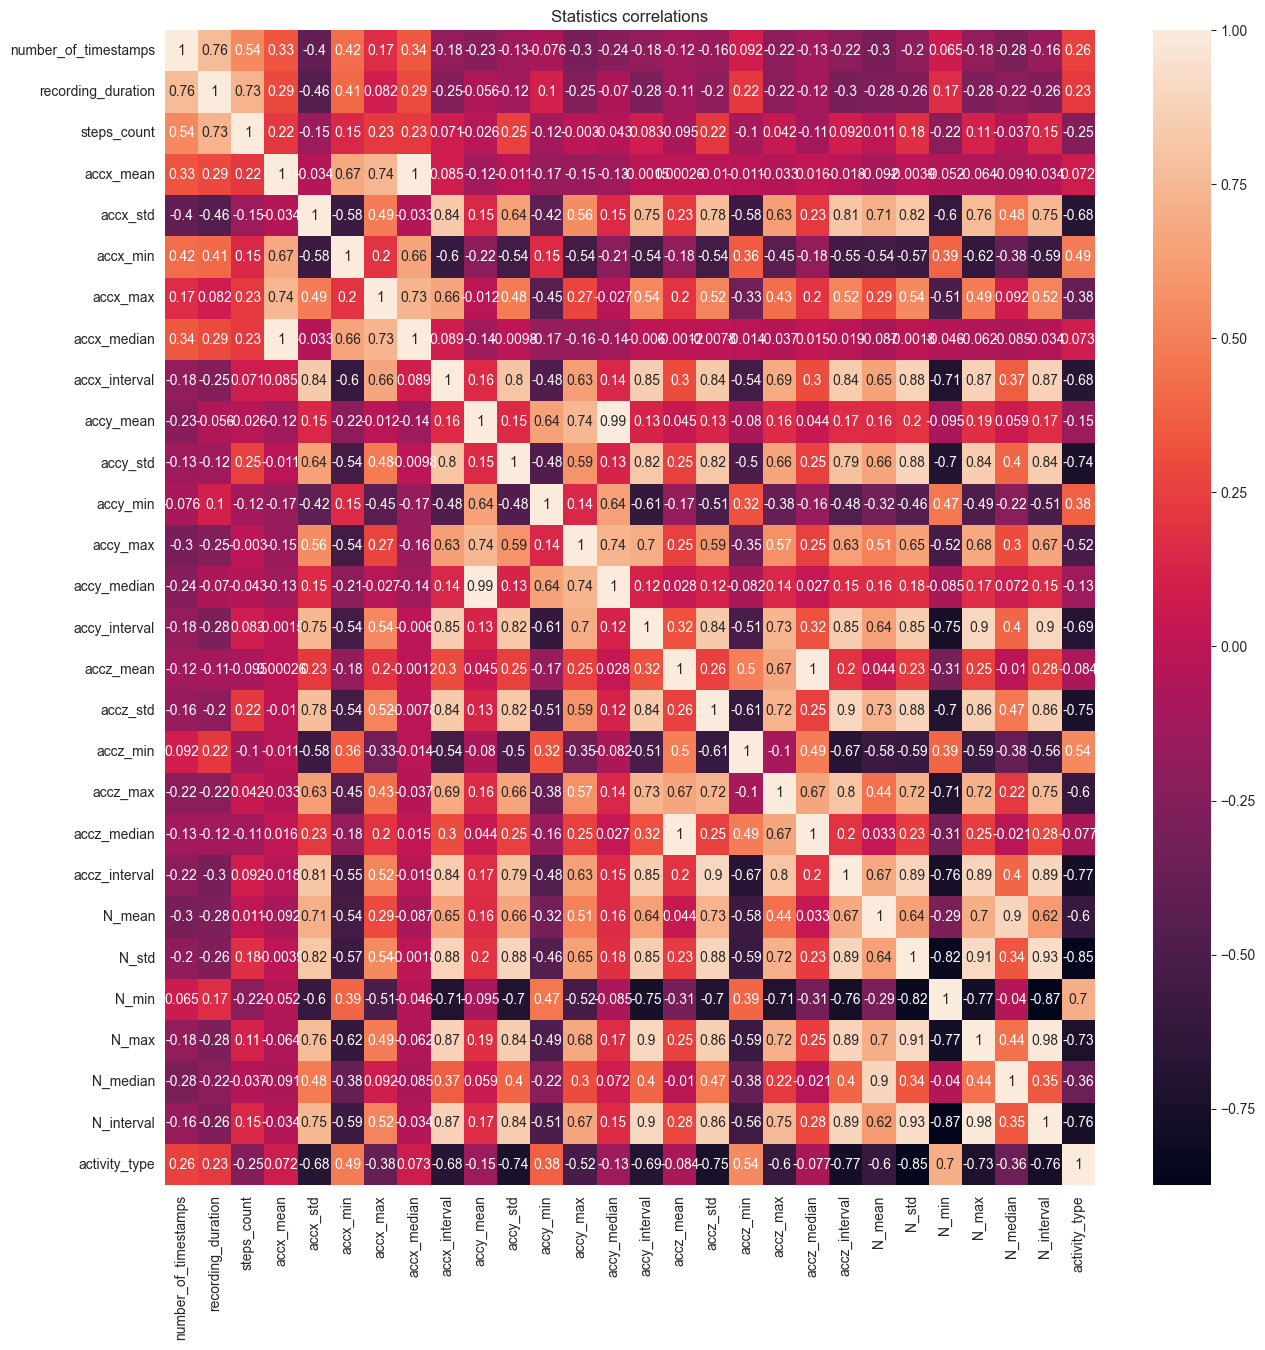

In [14]:
import seaborn as sns

plt.figure(figsize=(15, 15))
sns.heatmap(stats_dataframe.corr(), annot=True)
plt.title("Statistics correlations")
plt.show()

Some insights from the above matrix:

* The features are most positively correlated with `activity_type` are `N_min` (0.7), `accz_min` (0.54) and `accx_min` (0.49).
* The features are most negatively correlated with `activity_type` are `N_std` (-0.85), `accz_interval` (-0.77) and `N_interval` (-0.76).
* The `steps_count` feature is only positively correlated with `number_of timestamps` (0.54) and `recording_duration` (0.73).

We expect the models to consider these features as more important for prediction.

## 2. Processing the data

While processing the data before applying ML models, we encounter the following problem: the dataframes have the same amount of column but a different amount of rows, so before using any models on the data we need to process the data such that all samples have the same shape.

Thus, we transform each DataFrame into a single row with the aggregated statistics as they appear in part 1 above (we basically use the `stats_dataframe` DataFrame).

We remove some unwanted columns:

1. For the activity classification model, we remove the following columns from the data:
    1. `number_of_timestamps` - The number of recorded timestamps should not affect the activity type.
    2. `recording_duration` - The duration of the recording should not affect the activity type.
    3. `steps_count` - The number of recorded steps should not affect the activity type.
2. For the steps regression model, we do not remove any columns, as we think all the column can help the model achieve good results.

In [15]:
stats_dataframe_for_classification = stats_dataframe.drop(
    columns=['number_of_timestamps', 'recording_duration', 'steps_count'])

stats_dataframe_for_regression = stats_dataframe.copy()

## 3. Models selection, training and predictions

### 3.1 Classification model

We split the label from the rest of the data:

In [16]:
classification_X, classification_y = stats_dataframe_for_classification.drop(columns=['activity_type']), \
    stats_dataframe_for_classification['activity_type']

We choose the following models for the classification task - Logistic Regression, KNN, Random Forest and XGBoost.

In [17]:
import warnings

warnings.filterwarnings("ignore")

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.model_selection import GridSearchCV

# Finding the best KNN model parameters
knn_model = KNeighborsClassifier()
knn_parameters = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

knn_grid_search = GridSearchCV(estimator=knn_model,
                               param_grid=knn_parameters,
                               scoring='accuracy',
                               cv=5)

knn_grid_search.fit(classification_X, classification_y)
print(
    f"Best KNN parameters are {knn_grid_search.best_params_} with an accuracy score of {round(knn_grid_search.best_score_, 4)}.")

# Finding the best Logistic Regression model parameters
logreg_model = LogisticRegression()
logreg_parameters = {
    'penalty': [None, 'l2', 'l1', 'elasticnet'],
    'C': [0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2],
    'fit_intercept': [True, False],
    'solver': ['lbfgs', 'liblinear']
}

logreg_grid_search = GridSearchCV(estimator=logreg_model,
                                  param_grid=logreg_parameters,
                                  scoring='accuracy',
                                  cv=5)

logreg_grid_search.fit(classification_X, classification_y)
print(
    f"Best Logistic Regression parameters are {logreg_grid_search.best_params_} with an accuracy score of {round(logreg_grid_search.best_score_, 4)}.")

# Finding the best Random Forest model parameters
ranfor_model = RandomForestClassifier()
ranfor_parameters = {
    'n_estimators': [5, 7, 10, 12, 15, 17, 20, 25, 30],
    'max_depth': [None, 5, 10, 15, 20, 25, 30],
    'max_features': ['sqrt', 'log2']
}

ranfor_grid_search = GridSearchCV(estimator=ranfor_model,
                                  param_grid=ranfor_parameters,
                                  scoring='accuracy',
                                  cv=5)

ranfor_grid_search.fit(classification_X, classification_y)
print(
    f"Best Random Forest parameters are {ranfor_grid_search.best_params_} with an accuracy score of {round(ranfor_grid_search.best_score_, 4)}.")

# Finding the best XGBoost model parameters
xgb_model = xgb.XGBClassifier()
xgb_parameters = {
    'n_estimators': [5, 7, 10, 12, 15, 17, 20, 25, 30],
    'max_depth': [None, 5, 10, 15, 20, 25, 30],
    'grow_policy': ['depthwise', 'lossguide']
}

xgb_grid_search = GridSearchCV(estimator=xgb_model,
                               param_grid=xgb_parameters,
                               scoring='accuracy',
                               cv=5)

xgb_grid_search.fit(classification_X, classification_y)
print(
    f"Best XGBoost parameters are {xgb_grid_search.best_params_} with an accuracy score of {round(xgb_grid_search.best_score_, 4)}.")

Best KNN parameters are {'n_neighbors': 3, 'p': 1, 'weights': 'distance'} with an accuracy score of 0.8898.
Best Logistic Regression parameters are {'C': 0.25, 'fit_intercept': True, 'penalty': 'l1', 'solver': 'liblinear'} with an accuracy score of 0.8644.
Best Random Forest parameters are {'max_depth': 15, 'max_features': 'log2', 'n_estimators': 25} with an accuracy score of 0.9383.
Best XGBoost parameters are {'grow_policy': 'depthwise', 'max_depth': None, 'n_estimators': 5} with an accuracy score of 0.8953.


As we can see, the Random Forest model achieves the highest accuracy score of 94.45% (the score may change between runs because of the algorithm's randomness). We retrain the model with the best parameters and check the features' importance:

In [18]:
classification_model = RandomForestClassifier(n_estimators=12, max_depth=10, max_features='sqrt')
classification_model.fit(classification_X, classification_y)

for feature_name, feature_importance in zip(classification_X.columns, classification_model.feature_importances_):
    print(f"{feature_name}: {round(feature_importance, 5)}")

accx_mean: 0.00549
accx_std: 0.02368
accx_min: 0.0045
accx_max: 0.0
accx_median: 0.01169
accx_interval: 0.04983
accy_mean: 0.0
accy_std: 0.09439
accy_min: 0.0
accy_max: 0.03072
accy_median: 0.00185
accy_interval: 0.02555
accz_mean: 0.04297
accz_std: 0.03883
accz_min: 0.09688
accz_max: 0.0155
accz_median: 0.0064
accz_interval: 0.12449
N_mean: 0.00778
N_std: 0.21078
N_min: 0.02646
N_max: 0.10263
N_median: 0.01353
N_interval: 0.06605


As expected, the two most important features are `accz_interval` and `accz_std`: we expect that when a person runs, the minimum and maximum values of the `ACC Z` column will be farther away from each other (and the other way around when a person is walking).

### 3.2 Regression model

We split the label from the rest of the data:

In [19]:
regression_X, regression_y = stats_dataframe_for_regression.drop(columns=['steps_count']), \
stats_dataframe_for_regression['steps_count']

We choose the following models for the regression task - KNN, Random Forest, Linear Regression and XGBoost.

In [20]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet

# Finding the best KNN model parameters
knn_reg_model = KNeighborsRegressor()
knn_reg_parameters = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

knn_reg_grid_search = GridSearchCV(estimator=knn_reg_model,
                                   param_grid=knn_reg_parameters,
                                   scoring='neg_root_mean_squared_error',
                                   cv=5)

knn_reg_grid_search.fit(regression_X, regression_y)
print(
    f"Best KNN parameters are {knn_reg_grid_search.best_params_} with an accuracy score of {round(knn_reg_grid_search.best_score_, 4)}.")

# Finding the best Random Forest model parameters
ranfor_reg_model = RandomForestRegressor()
ranfor_reg_parameters = {
    'n_estimators': [5, 7, 10, 12, 15, 17, 20, 25, 30],
    'max_depth': [None, 5, 10, 15, 20, 25, 30],
    'max_features': ['sqrt', 'log2']
}

ranfor_reg_grid_search = GridSearchCV(estimator=ranfor_reg_model,
                                      param_grid=ranfor_reg_parameters,
                                      scoring='neg_root_mean_squared_error',
                                      cv=5)

ranfor_reg_grid_search.fit(regression_X, regression_y)
print(
    f"Best Random Forest parameters are {ranfor_reg_grid_search.best_params_} with an accuracy score of {round(ranfor_reg_grid_search.best_score_, 4)}.")

# Finding the best Linear Regression model parameters
enet_model = ElasticNet()
enet_parameters = {
    'l1_ratio': [0, 1, 0.25, 0.5, 0.75],
    'positive': [True, False]
}

enet_grid_search = GridSearchCV(estimator=enet_model,
                                param_grid=enet_parameters,
                                scoring='neg_root_mean_squared_error',
                                cv=5)

enet_grid_search.fit(regression_X, regression_y)
print(
    f"Best Linear Regression parameters are {enet_grid_search.best_params_} with an accuracy score of {round(enet_grid_search.best_score_, 4)}.")

# Finding the best XGBoost model parameters
xgb_reg_model = xgb.XGBRegressor()
xgb_reg_parameters = {
    'n_estimators': [5, 7, 10, 12, 15, 17, 20, 25, 30],
    'max_depth': [None, 5, 10, 15, 20, 25, 30],
    'grow_policy': ['depthwise', 'lossguide']
}

xgb_reg_grid_search = GridSearchCV(estimator=xgb_reg_model,
                                   param_grid=xgb_reg_parameters,
                                   scoring='neg_root_mean_squared_error',
                                   cv=5)

xgb_reg_grid_search.fit(regression_X, regression_y)
print(
    f"Best XGBoost parameters are {xgb_reg_grid_search.best_params_} with an accuracy score of {round(xgb_reg_grid_search.best_score_, 4)}.")

Best KNN parameters are {'n_neighbors': 9, 'p': 1, 'weights': 'distance'} with an accuracy score of -27.2587.
Best Random Forest parameters are {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 10} with an accuracy score of -24.9215.
Best Linear Regression parameters are {'l1_ratio': 1, 'positive': True} with an accuracy score of -27.4127.
Best XGBoost parameters are {'grow_policy': 'depthwise', 'max_depth': 5, 'n_estimators': 10} with an accuracy score of -28.4014.


As before, the Random Forest model achieves the best results, with a negative RMSE score of -24.24 (the score may change between runs because of the algorithm's randomness). We retrain the model with the best parameters and check the features' importance:

In [21]:
regression_model = RandomForestClassifier(n_estimators=17, max_depth=10, max_features='log2')
regression_model.fit(classification_X, classification_y)

for feature_name, feature_importance in zip(regression_X.columns, regression_model.feature_importances_):
    print(f"{feature_name}: {round(feature_importance, 5)}")

number_of_timestamps: 0.00493
recording_duration: 0.01587
accx_mean: 0.00463
accx_std: 0.00109
accx_min: 0.00744
accx_max: 0.01561
accx_median: 0.0016
accx_interval: 0.071
accy_mean: 0.00649
accy_std: 0.00703
accy_min: 0.01807
accy_max: 0.00839
accy_median: 0.03114
accy_interval: 0.18269
accz_mean: 0.05089
accz_std: 0.02253
accz_min: 0.01513
accz_max: 0.14007
accz_median: 0.02239
accz_interval: 0.0654
N_mean: 0.09749
N_std: 0.00488
N_min: 0.01698
N_max: 0.18826


Saving the models:

In [23]:
import pickle

classification_model_directory = './models/classification_model.sav'
regression_model_directory = './models/regression_model.sav'

pickle.dump(classification_model, open(classification_model_directory, 'wb'))
pickle.dump(regression_model, open(regression_model_directory, 'wb'))